In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib
import warnings
warnings.filterwarnings("ignore")
base_path = "https://raw.githubusercontent.com/sinc-lab/rna-llm-folding/refs/heads/main/"
models = ["one-hot", "ERNIE-RNA", "RNAErnie", "RiNALMo",  "rna-msm", "rnabert", "rnafm"]

### Non-canonical base-pair prediction

In [24]:
def f1_strict(ref_bp, pre_bp):
    """F1 score strict, same as triangular but less efficient"""
    # corner case when there are no positives
    if len(ref_bp) == 0 and len(pre_bp) == 0:
        return 1.0, 1.0, 1.0

    tp1 = 0
    for rbp in ref_bp:
        if rbp in pre_bp:
            tp1 = tp1 + 1
    tp2 = 0
    for pbp in pre_bp:
        if pbp in ref_bp:
            tp2 = tp2 + 1

    fn = len(ref_bp) - tp1
    fp = len(pre_bp) - tp1

    tpr = pre = f1 = 0.0
    if tp1 + fn > 0:
        tpr = tp1 / float(tp1 + fn)  # sensitivity (=recall =power)
    if tp1 + fp > 0:
        pre = tp2 / float(tp1 + fp)  # precision (=ppv)
    if tpr + pre > 0:
        f1 = 2 * pre * tpr / (pre + tpr)  # F1 score

    return tpr, pre, f1

def get_f1(x):
    r, p, f1 = f1_strict(x["ref"], x["folding"])
    return f1

def get_nc_f1(x):
    r, p, f1 = f1_strict(x["ref_nc"], x["pred_nc"])
    return f1

def get_canonic_f1(x):
    ref = [bp for bp in x["ref"] if bp not in x["ref_nc"]]
    pred = [bp for bp in x["folding"] if bp not in x["pred_nc"]]

    r, p, f1 = f1_strict(ref, pred)
    return f1

NT_DICT = {
    "R": ["G", "A"],
    "Y": ["C", "U"],
    "K": ["G", "U"],
    "M": ["A", "C"],
    "S": ["G", "C"],
    "W": ["A", "U"],
    "B": ["G", "U", "C"],
    "D": ["G", "A", "U"],
    "H": ["A", "C", "U"],
    "V": ["G", "C", "A"],
    "N": ["G", "A", "C", "U"],
}

def pair_strength(pair):
    if "G" in pair and "C" in pair:
        return 3
    if "A" in pair and "U" in pair:
        return 2
    if "G" in pair and "U" in pair:
        return 0.8

    if pair[0] in NT_DICT and pair[1] in NT_DICT:
        n0, n1 = NT_DICT[pair[0]], NT_DICT[pair[1]]
        # Possible pairs with other bases
        if ("G" in n0 and "C" in n1) or ("C" in n0 and "G" in n1):
            return 3
        if ("A" in n0 and "U" in n1) or ("U" in n0 and "A" in n1):
            return 2
        if ("G" in n0 and "U" in n1) or ("U" in n0 and "G" in n1):
            return 0.8

    return 0

In [11]:
pdb = pd.read_csv(f"{base_path}data/pdb-rna.csv", index_col="id")
splits = pd.read_csv(f"{base_path}data/pdb-rna_splits.csv", index_col="id")
test = pdb.loc[splits[splits.partition=="test"].index]

In [12]:
summary = []
for model_name in models:
    
    pred = pd.read_csv(f"{base_path}/results/PDB-RNA/{model_name}/preds_test.csv", index_col="id")
    
    for i, item in test.iterrows():

        out = json.loads(pred.loc[i].base_pairs)
        ref = json.loads(item.base_pairs)
        
        ref_nc = [bp for bp in ref if pair_strength([item.sequence[bp[0]-1], item.sequence[bp[1]-1]]) == 0]
        pred_nc = [bp for bp in out if pair_strength([item.sequence[bp[0]-1], item.sequence[bp[1]-1]]) == 0]


        summary.append({"id": item.name, "model_name": model_name, "ref": ref, "folding": out, 
                        "ref_nc": ref_nc, "pred_nc": pred_nc})

summary = pd.DataFrame(summary)

summary["F1"] = summary.apply(get_f1, axis=1)
summary["canonic_f1"] = summary.apply(get_canonic_f1, axis=1)
summary["nc_f1"] = summary.apply(get_nc_f1, axis=1)
summary = summary[summary.ref_nc.apply(lambda x: len(x)>1)]

In [13]:

llm_names = {
    "rna-msm": "RNA-MSM",
    "rnafm": "RNA-FM",
    "rnabert": "RNABERT",
}
K = 50

df_filt = summary.set_index("id")[["model_name", "nc_f1"]].rename(columns={"nc_f1": "F1", "model_name": "LLM"}).replace(llm_names)
sorted_index = ['ERNIE-RNA', 'RiNALMo', 'RNA-MSM', 'one-hot', 'RNA-FM', 'RNAErnie' , 'RNABERT']
medians = [np.median(df_filt[df_filt.LLM==method].F1) for method in sorted_index]

f1 = []
f1_swarm = []
for method in sorted_index:
    f1_values = np.array(df_filt[df_filt.LLM==method].F1)
    f1.append(f1_values)
    if len(f1_values) > K:
        kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(f1_values.reshape(-1,1))
        f1_swarm.append(kmeans.cluster_centers_)
    else:
        f1_swarm.append(f1_values)
f1_swarm = np.array(f1_swarm).squeeze().T
f1 = np.array(f1).squeeze().T

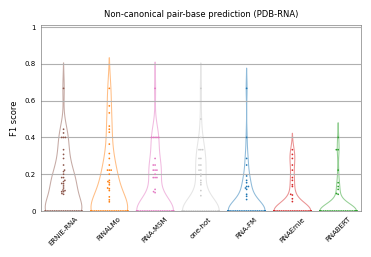

In [14]:
matplotlib.rc('axes', edgecolor='gray')

w = 10.5#6.13
h = 6.13
FS = 6
K = 50

fig, ax = plt.subplots(1, 1)  #, figsize=(6,6))
fig.set_size_inches([w/2.54, h/2.54])
plt.rcParams.update({'font.size': 5})

llm_colors={'RNA-FM': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'RiNALMo': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'RNABERT': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 'RNAErnie': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0),
 'one-hot': (.8, .8, .8, 1),
 'ERNIE-RNA': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 'RNA-MSM': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
}

colors = [llm_colors[m] for m in sorted_index]
sns.violinplot(f1, inner=None, ax=ax, palette=colors, alpha=.5, fill=None, linewidth=0.75)
sns.swarmplot(f1_swarm, size=1.25, ax=ax, alpha=1., palette=colors)
ax.set_ylabel('F1 score', fontsize=6)
ax.set_xlabel('')
ax.set_xticks(range(len(sorted_index)))
ax.set_xticklabels([f'{method}' for method in sorted_index], fontsize=5, rotation=45)
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=5)

ax.set(title='Non-canonical pair-base prediction (PDB-RNA)')
ax.set(ylim=(0, 1.01))

ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.tick_params(axis='x', which='both', width=0.5)
ax.tick_params(axis='y', which='major', width=0.5)

x_values = range(len(medians))
ax.grid(True, axis='y');

### Structure motif performance

In [ ]:
!wget https://raw.githubusercontent.com/hendrixlab/bpRNA/master/bpRNA.pl
!apt-get install cpanminus
!cpanm Graph

In [5]:
import pandas as pd
    
data = pd.read_csv(f"{base_path}data/bpRNA.csv", index_col="id")
splits = pd.read_csv(f"{base_path}data/bpRNA_splits.csv", index_col="id")
data = data.loc[splits[splits.partition=="new"].index]

In [6]:
# generate all bpseq files
import os
os.makedirs("tmp/", exist_ok=True)
for k in range(len(data)):
    with open(f"tmp/{data.iloc[k].name}.bpseq", "w") as fout:
        seq = data.iloc[k].sequence
        basepairs = json.loads(data.iloc[k].base_pairs)
        for k, s in enumerate(seq):
            n2 = 0
            for bp in basepairs:
                if bp[0] == k+1:
                    n2 = bp[1]
                    break
                elif bp[1] == k+1:
                    n2 = bp[0]
                    break

            fout.write(f"{k+1} {s} {n2}\n")

In [7]:
# generate all ref st files
nerr = 0
os.chdir("tmp/")
for k in range(len(data)):
    !rm log
    !perl ../bpRNA.pl {data.iloc[k].name}.bpseq 2>log
    errors = open("log").readlines()
    if errors:
        print("error", nerr, errors)
        nerr+=1

In [29]:
import ast

MATCHING_BRACKETS = [
    ["(", ")"],
    ["[", "]"],
    ["{", "}"],
    ["<", ">"],
    ["A", "a"],
    ["B", "a"],
]

def fold2bp(struc, xop="(", xcl=")"):
    """Get base pairs from one page folding (using only one type of brackets).
    BP are 1-indexed"""
    openxs = []
    bps = []
    if struc.count(xop) != struc.count(xcl):
        return False
    for i, x in enumerate(struc):
        if x == xop:
            openxs.append(i)
        elif x == xcl:
            if len(openxs) > 0:
                bps.append([openxs.pop() + 1, i + 1])
            else:
                return False
    return bps


def dot2bp(struc):
    bp = []
    if not set(struc).issubset(
        set(["."] + [c for par in MATCHING_BRACKETS for c in par])
    ):
        return False

    for brackets in MATCHING_BRACKETS:
        if brackets[0] in struc:
            bpk = fold2bp(struc, brackets[0], brackets[1])
            if bpk:
                bp = bp + bpk
            else:
                return False
    return list(sorted(bp))

def get_motif_1nts(st_file, motif_id):

    lines = open(st_file, 'r').readlines()
    motifs = lines[5].strip()
    
    nts = [n+1 for n, m in enumerate(motifs) if m == motif_id]
    
    return nts

def f1_motif(preds, refs, motif_id):
    # mean F1 score for a given motif

    recs, pres, f1s = [], [], []
    for seq_id, row in preds.iterrows():
        ref_st_file = f"{seq_id}.st"

        # get the nucleotides positions with the motif
        nts_in_motif = get_motif_1nts(ref_st_file, motif_id)

        ref_bp = ast.literal_eval(refs.loc[seq_id, "base_pairs"])

        folding = row["base_pairs"]
        if folding[0] in {'.', '(', ')'}:
            pred_bp = dot2bp(folding)
        else:
            pred_bp = ast.literal_eval(folding)

        _, _, f1_full = f1_strict(ref_bp, pred_bp)
        #print(seq_id,f1_full)

        # remove base pairs not in nts_in_motif
        ref_bp_motif = [bp for bp in ref_bp if bp[0] in nts_in_motif and bp[1] in nts_in_motif]
        pred_bp_motif = [bp for bp in pred_bp if bp[0] in nts_in_motif and bp[1] in nts_in_motif]

        rec_motif, pre_motif, f1_motif = f1_strict(ref_bp_motif, pred_bp_motif)
        f1s.append(f1_motif)
        recs.append(rec_motif)
        pres.append(pre_motif)

    return sum(recs) / len(recs), sum(pres) / len(pres), sum(f1s) / len(f1s)

In [30]:
import os

motifs = ['S', 'M', 'I', 'B', 'H', 'E', 'X']
#
summary = []
for motif_id in motifs:
    print(motif_id)
    for model in models:
        preds = pd.read_csv(f"{base_path}/results/bpRNA_new/{model}/preds_new_test.csv", index_col="id")
        summary.append([model, motif_id, f1_motif(preds, data, motif_id)])

summary = pd.DataFrame(summary, columns=["method", "motif", "f1"])
summary["rec"] = summary.f1.apply(lambda x: x[0])
summary["pre"] = summary.f1.apply(lambda x: x[1])
summary["f1"] = summary.f1.apply(lambda x: x[2])

S
M
I
B
H
E
X


In [31]:
methods = ['one-hot', 'RNAErnie', 'RNABERT', 'ERNIE-RNA', 'RiNALMo',
       'RNA-MSM', 'RNA-FM']

llm_names = {
    "rna-msm": "RNA-MSM",
    "rnafm": "RNA-FM",
    "rnabert": "RNABERT",
}
llm_colors={'RNA-FM': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'RiNALMo': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'RNABERT': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 'RNAErnie': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0),
 'one-hot': (.8, .8, .8, 1),
 'ERNIE-RNA': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 'RNA-MSM': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
}

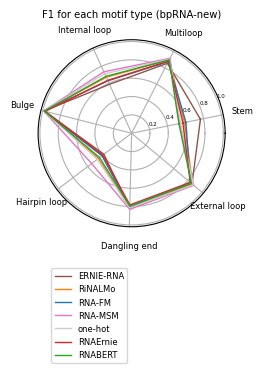

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
df = summary.replace(llm_names).replace({"S": "Stem", "M": "Multiloop", "I": "Internal loop",
"B": "Bulge", "H": "Hairpin loop", "E": "Dangling end", "X": "External loop"})
#methods = df['method'].unique()
methods = ['ERNIE-RNA', 'RiNALMo', 'RNA-FM', 'RNA-MSM', 'one-hot', 'RNAErnie', 'RNABERT']
motifs = df['motif'].unique()
num_vars = len(motifs)

tam_w = 6.13
tam_h = 12.13
FS = 6

# Set the angle for each motif
angles = [n / float(num_vars) * 2 * pi  +.2 for n in range(num_vars)]
angles += angles[:1]  # Ensure the plot is closed

# Initialize the plot
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
fig.set_size_inches([tam_w/2.54, tam_h/2.54])
plt.rcParams.update({'font.size': 6})

# Loop through each method and plot
for method in methods:
    # Filter the dataframe for the current method
    method_data = df[df['method'] == method]

    # Create values for the plot, and close the loop by repeating the first value
    values = method_data['f1'].tolist()
    values += values[:1]

    # Plot the data
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=method, color=llm_colors[method])

# Add labels for each motif
plt.xticks(angles[:-1], motifs)
plt.title('F1 for each motif type (bpRNA-new)')

plt.legend(loc='upper right', bbox_to_anchor=(0.5, -.2))
ax.tick_params(axis='y', labelsize=4)
#plt.savefig(f'sample_data/fig2_e.svg')